In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.linear_model import RANSACRegressor

import math


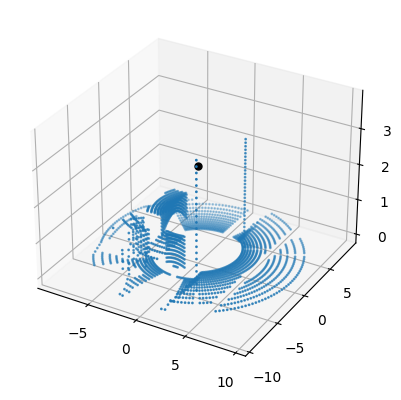

In [2]:
file = '_out/milestonefour/00016477.ply'
file = '_out/lidar/01516050.ply'

# Load data
data = np.loadtxt(file, skiprows=7)

# Flip X axis
data[:, 0] = -data[:, 0]

# Apply Z-axis offset (LIDAR sensor position)
data[:,2] = 2.5 - data[:,2]

# Plot data
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=1)
ax.scatter(0, 0, 2.5, s=25, c='black')
plt.show()


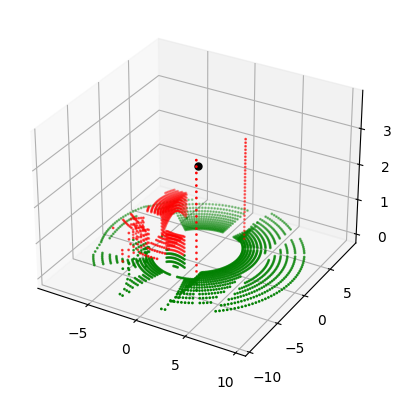

In [3]:
# Determine ground plane using RANSAC (RANdom SAmple Consensus) algorithm

# X and Y coordinates
X = data[:, :2]

# Z coordinate (regression target)
y = data[:, 2]

ransac = RANSACRegressor(residual_threshold=0.4)
ransac.fit(X, y)

# Compute inliers and outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Split data into inliers and outliers
inliers = data[inlier_mask]
outliers = data[outlier_mask]

# Plot data
ax = plt.axes(projection='3d')
ax.scatter(inliers[:, 0], inliers[:, 1], inliers[:, 2], s=1, c='green')
ax.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], s=1, c='red')
ax.scatter(0, 0, 2.5, s=25, c='black')

plt.show()

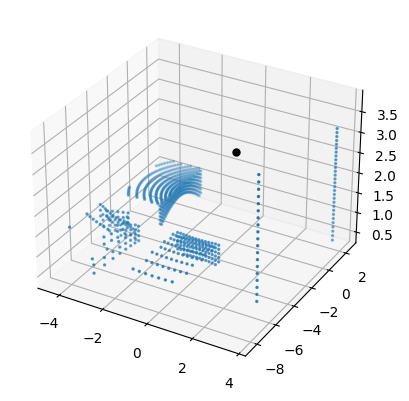

In [4]:
# Remove ground plane from data
data = data[outlier_mask]

# Plot data
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=2)
ax.scatter(0, 0, 2.5, s=25, c='black')
plt.show()


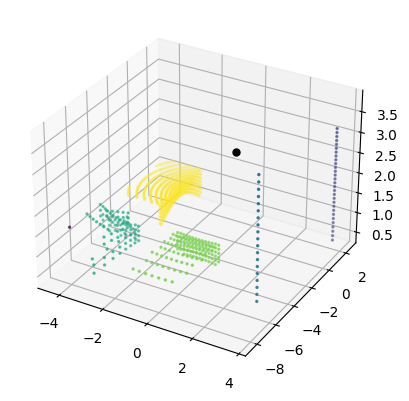

In [5]:
# Cluster points based on density
db = DBSCAN(eps=1.1, min_samples=10)
db.fit(data)

# Segment data based on labels
clusters = np.hstack((data, db.labels_.reshape(-1, 1)))
clusters = clusters[clusters[:, -1].argsort()]
clusters = np.split(clusters[:, :-1], np.unique(clusters[:, -1], return_index=True)[1][1:])

# Plot data
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=2, c=db.labels_)
ax.scatter(0, 0, 2.5, s=25, c='black')

plt.show()


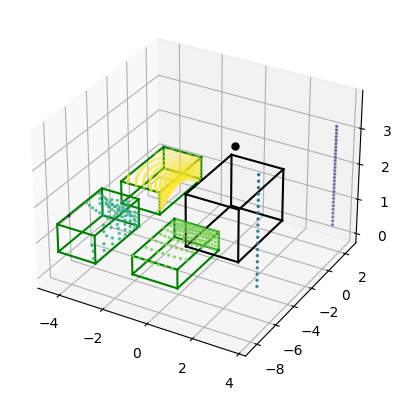

In [6]:
obstacles = []

# Compute bounding box for each cluster
for cluster in clusters:
    x_min = np.min(cluster[:, 0])
    y_min = np.min(cluster[:, 1])
    z_min = np.min(cluster[:, 2])

    x_max = np.max(cluster[:, 0])
    y_max = np.max(cluster[:, 1])
    z_max = np.max(cluster[:, 2])

    # Consider only obstacles with some volume (excludes false positives like lantern poles and traffic signs)
    volume = (x_max - x_min) * (y_max - y_min) * (z_max - z_min)

    if volume > 0.1:
        obstacles.append([x_min, y_min, z_min, x_max, y_max, z_max, 'g'])

def render(x_min, y_min, z_min, x_max, y_max, z_max, c):
    # Plot bounding box
    ax.plot([x_min, x_min], [y_min, y_min], [z_min, z_max], c=c)
    ax.plot([x_min, x_min], [y_max, y_max], [z_min, z_max], c=c)
    ax.plot([x_max, x_max], [y_min, y_min], [z_min, z_max], c=c)
    ax.plot([x_max, x_max], [y_max, y_max], [z_min, z_max], c=c)

    ax.plot([x_min, x_max], [y_min, y_min], [z_min, z_min], c=c)
    ax.plot([x_min, x_max], [y_min, y_min], [z_max, z_max], c=c)
    ax.plot([x_min, x_max], [y_max, y_max], [z_min, z_min], c=c)
    ax.plot([x_min, x_max], [y_max, y_max], [z_max, z_max], c=c)

    ax.plot([x_min, x_min], [y_min, y_max], [z_min, z_min], c=c)
    ax.plot([x_min, x_min], [y_min, y_max], [z_max, z_max], c=c)
    ax.plot([x_max, x_max], [y_min, y_max], [z_min, z_min], c=c)
    ax.plot([x_max, x_max], [y_min, y_max], [z_max, z_max], c=c)

car = [
    [-1.2, -2.5, 0.0, 1.2, 2.5, 1.5, 'black'],
]

# Plot data
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=2, c=db.labels_)
ax.scatter(0, 0, 2.5, s=25, c='black')

for x_min, y_min, z_min, x_max, y_max, z_max, c in obstacles:
    render(x_min, y_min, z_min, x_max, y_max, z_max, c)

for x_min, y_min, z_min, x_max, y_max, z_max, c in car:
    render(x_min, y_min, z_min, x_max, y_max, z_max, c)

plt.show()


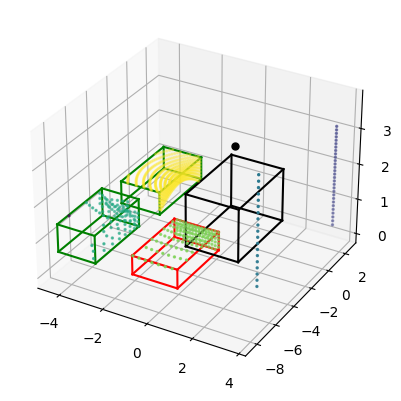

In [7]:
# Compute shortest distance from point to to obstacles
def distance_to(x, y, z, x_min, y_min, z_min, x_max, y_max, z_max):
    # Check if the point is inside the cube
    if x_min <= x <= x_max and y_min <= y <= y_max and z_min <= z <= z_max:
        return 0.0

    # Calculate the distance to the cube's surfaces along each axis
    dx = max(0, x_min - x, x - x_max)
    dy = max(0, y_min - y, y - y_max)
    dz = max(0, z_min - z, z - z_max)

    # Calculate the Euclidean distance between the point and the cube's surfaces
    distance = math.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

    return distance

# Plot data
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=2, c=db.labels_)
ax.scatter(0, 0, 2.5, s=25, c='black')

for x_min, y_min, z_min, x_max, y_max, z_max, c in obstacles:
    if distance_to(0, -2.5, 0, x_min, y_min, z_min, x_max, y_max, z_max) < 2.0:
        c = 'r'
    render(x_min, y_min, z_min, x_max, y_max, z_max, c)

for x_min, y_min, z_min, x_max, y_max, z_max, c in car:
    render(x_min, y_min, z_min, x_max, y_max, z_max, c)

plt.show()
